## 9.9 语义分割和数据集

### 9.9.1 图像分割和实例分割
### 9.9.2 Pascal VOC2012语义分割数据集

In [1]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
import os
import skimage.io
import d2lzh as d2l
import numpy as np
import time

/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs/rknn/lib/python3.6/site-packages

In [2]:
def download_voc_pascal(data_dir='../data'):
    voc_dir = os.path.join(data_dir, 'VOCdevkit/VOC2012')
    url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
           '/VOCtrainval_11-May-2012.tar')
    sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'
   
    # 用下载工具下更快
    # fname = keras.utils.get_file(
    #     fname='VOCtrainval_11-May-2012.tar',
    #     cache_dir=voc_dir,
    #     origin=url,
    #     extract=True,
    #     hash_algorithm='sha1',
    #     file_hash=sha1)
    
    return voc_dir
    
voc_dir = download_voc_pascal()

In [3]:
def read_voc_images(root=voc_dir, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (
        root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = skimage.io.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = skimage.io.imread(
            '%s/SegmentationClass/%s.png' % (root, fname))
    return features, labels

train_features, train_labels = read_voc_images()

画出前5张输入图和标签

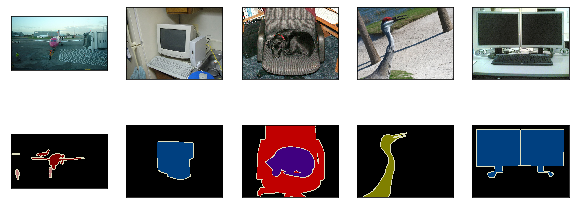

In [4]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n);

In [5]:
# 该常量已保存在d2lzh包中方便以后使用
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
# 该常量已保存在d2lzh包中方便以后使用
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [6]:
colormap2label = np.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在d2lzh包中方便以后使用
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]]), 'aeroplane')

#### 9.9.2.1 预处理数据
做随机同尺寸剪裁

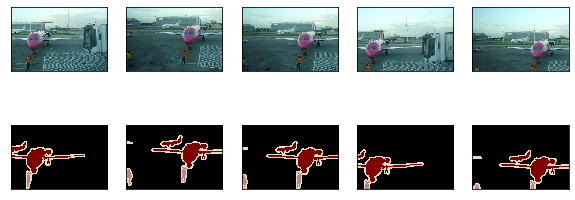

In [8]:
# 本函数已保存在d2lzh包中方便以后使用
def voc_rand_crop(feature, label, height, width):
    combine = tf.concat([feature, label], axis=2)
    combine = tf.random_crop(combine, (height, width, 7))
    return combine[:,:,0:3].numpy(), combine[:,:,3:6].numpy()

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

#### 9.9.2.2 自定义语义分割数据集类


In [9]:
class VOCSegDataset(keras.utils.Sequence):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        super().__init__()
        self.rgb_mean = np.array([0.485, 0.456, 0.406])
        self.rgb_std = np.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')
        
    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]
        
    def __getitem__(self, index):
        feature, label = voc_rand_crop(self.features[index], self.labels[index],
                                       *self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)
    

#### 9.9.2.3 读取数据集

In [11]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir, colormap2label)
voc_test = VOCSegDataset(False, crop_size, voc_dir, colormap2label)

read 1114 examples
read 1078 examples


In [12]:
for X, Y in voc_train:
    print(X.shape)
    print(Y.shape)
    break

(3, 320, 480)
(320, 480)
